# Editing Geographic Features in Python

## Introduction

One major benefit that I find working in Python for spatial analyses is the ability to create, customize, and define tools that are very specific to the required spatial or analytical task. Rather than being constrained to the set of tools defined by a GIS software, when working in Python I can create a function that's very specific to the task of a given project. 

I recently had a request from a colleague that required some editing and manipulation of geographic features in order to achieve the desired output. Essentially, we needed to divide the city of Berkeley into two geographic areas separated by a street, which does not extend the entire length of the city boundary (the area East of Sacramento Street was to be one sample area and the area West of Sacramento street was to be another sample area).

While this could certainly be done in ArcMap, I couldn't think of an elegant way to edit the features in the exact way that we needed. And honestly, what I did in this notebook was certainly overkill for this project and the easiest approach would probably to have just edited the feature manually. However, I can easily imagine situations where it is important to have these types of edits automated, and therefore I took this as a good opportunity to show some more of the capabilities of open source GIS in Python.

I can certainly think of some cases in which these tools might may not work. However, the beauty of doing GIS this way is that these tools and functions can be adapted or generalized to work in pretty much any situation. Additionally, I apply them to just 1 road in 1 city. They can easily be applied to a dataset as a whole to ensure that all features conform to a certain set of topological rules.

Anyway, in the following example, I read in city boundary and street files (downloaded as GeoJSON files from the City of Berkeley Open Data Portal) as Shapely geometry objects. I write a few functions using built in Shapely operations to clean up the geometry and then go ahead and divide Berkeley in two. All of the geometric manipulation will be done on the street file, not the city boundary. The crux of the issue is that before I can use the street to divide the city, I will need a polyline that runs continuously to and touches the city boundary at two points.

## Reading in the City Boundary and Street Files
First I need to import the necessary modules. I am basically using ```shapely``` for all of the geometric / analytical work, ```geopandas``` for storting shapely geometries, ```math``` for some basic mathematical functions, ```matplotlib``` for plotting, and ```itertools``` to efficiently iterate through road segment geometries.

In [1]:
#Import necessary modules
%matplotlib inline
import shapely
from shapely.geometry import *
from shapely.ops import *
import geopandas as gpd
from math import *
from matplotlib import pyplot as plt
import itertools


I use Geopandas as an easy way to read in GeoJSON files (it could have just as easily been a Shapefile). Geopandas uses Fiona to read, write, and project spatial data and Shapely to analyze / manipulate it. My first steps are to read in the city boundary and street files, convert them to the same projected coordinate system, and convert the relevant data to Shapely geometries.

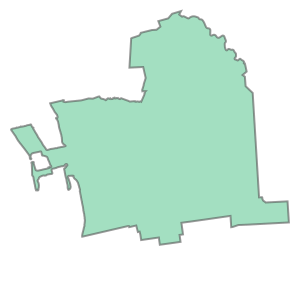

In [2]:
berk_boundary=gpd.read_file('Data/Land Boundary.geojson')
CRS=berk_boundary.crs
#Convert geojson to NAD 83 / California Teale Albers
berk_boundary=berk_boundary.to_crs(epsg=3310)

#Get a shapely geometry as the union of all features in the city boundary GeoDataFrame (it's just 1 feature)
berk_boundary=berk_boundary.unary_union
berk_boundary

In [3]:
roads=gpd.read_file('Data/Streets Network.geojson')
#convert roads to California Teale Albers as well
roads=roads.to_crs(epsg=3310)
roads.head()

,block_addr,category,f_addl,f_addr,fullname,geometry,pav_width_,street_nam,street_typ,t_addl,t_addr
0,block of The Uplands Ramp,MINOR,0.0,0.0,THE UPLANDS PATH,(LINESTRING (-197315.4054627922 -15713.0555711...,0.0,THE UPLANDS,PATH,0.0,0.0
1,block of Caldecott Ln,MAJOR,0.0,0.0,CALDECOTT LN,(LINESTRING (-195262.9533869634 -15776.0892984...,0.0,CALDECOTT,LN,0.0,0.0
2,block of Caldecott Ln,MAJOR,0.0,0.0,CALDECOTT LN,(LINESTRING (-195312.2409801947 -15865.9438577...,0.0,CALDECOTT,LN,0.0,0.0
3,block of Nogales St Ramp,MINOR,0.0,0.0,NOGALES ST PATH,(LINESTRING (-197196.2942632891 -15691.4374610...,0.0,NOGALES ST,PATH,0.0,0.0
4,block of The Uplands Ramp,PEDESTRIAN,0.0,0.0,THE UPLANDS PATH,(LINESTRING (-197096.768910611 -15690.86442491...,0.0,THE UPLANDS,PATH,0.0,0.0


Dealing with the road segments gets a little more complicated. I first use a Pandas query and Geopandas spatial query to extract the road segments named "Sacramento" that intersect our city boundary. However, this gives us road <i> segments</i> we are interested in having 1 line feature for Sacramento Street. As you see below, our street is actually made up of 38 line segments. I use the ```linemerge``` function in shapely, which merges contiguous segments of lines. 

In [4]:
sac_st_segments=roads[(roads.street_nam=='SACRAMENTO')&(roads.intersects(berk_boundary))].unary_union
print 'Street made of '+str(len(sac_st_segments))+' segments'

Street made of 38 segments


In [5]:
sac_st_merged_broken=linemerge(sac_st_segments)
print 'After merging, street made of '+str(len(sac_st_merged_broken))+' segments'

After merging, street made of 2 segments


## Issue 1: Snap Noncontiguous Line Features

As you can see above, even after merging out line segments, we still are left with two separate line objects. What's going on here? The ```linemerge``` function merges together all linestrings that butt up against each other. However, evidently there is a gap in Sacramento Street, which will prevent the segments from being merged, and in turn prevent our polygon from being divided by this line. The plot below shows this break.

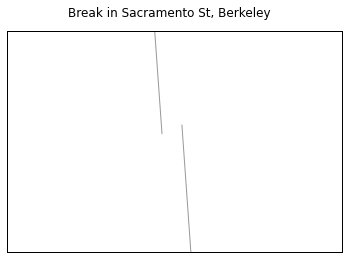

In [6]:
ax=gpd.GeoSeries(sac_st_merged_broken).plot()
plt.axis([-200576,-200453,-12910,-12829])
ax.set_xticks([])
ax.set_yticks([])
title=plt.suptitle('Break in Sacramento St, Berkeley',size='12')

### Identify the distance between the end points of two line segments

We want to snap together line segments that are within a certain distance of each other. However, it's first worth pointing out two different ways that distance can be measured between two line segments - (1) the minimum distance between two line segments, and (2) the minimum distance between the <i>end points</i> of two line segments. We are really interested in the latter, as the endpoint distance could be greater than the line segment distance (as it actually is in this example). This can be seen visually in the plot above, and I will also demonstrate it below by writing a function that calculates endpoint distance and comparing it to the built in distance function in Shapely.

In [7]:
sac_seg_0=sac_st_merged_broken[0]
sac_seg_1=sac_st_merged_broken[1]

segment_distance=sac_seg_0.distance(sac_seg_1)
print "Line segments are "+str(round(segment_distance,2))+ ' meters apart'

Line segments are 7.52 meters apart


In [8]:
def calc_end_point_dist(l1,l2):
    l1_end_points=l1.coords[0],l1.coords[-1]
    l2_end_points=l2.coords[0],l2.coords[-1]
    #Loop through the 4 combinations of endpoints that can be created between the 2 line segments 
    #Return the minimum distance between any of these 4 combinations
    return min(([LineString([p1,p2]).length for p1 in l1_end_points for p2 in l2_end_points]))

segment_endpoint_distance=calc_end_point_dist(sac_seg_0,sac_seg_1)
print "Line segment endpoints are "+str(round(segment_endpoint_distance,2))+ ' meters apart'

Line segment endpoints are 7.98 meters apart


As you can see above, the minimum distance between two line segments is 7.52 meters, but the distance between the two closest end points of these segments is 7.98 meters.

### Write a function to snap line segments within end point threshold distance 

Now I will write a function that takes a list of LineStrings (or a MultiLineString object) as its input and joins disjoint line segments with endpoints within a threshold distance of each other. The function loops through each combination of lines (in our case there is only 2 lines and therefore 1 combination), identifies those with endpoints that are within the specified distance, creates a new line segment as the shortest distance between these two segment endpoints, and then returns a newly merged LineString object. The output will be a LineString if disjoint lines are within the minimum threshold, or a MultiLineString if any of the disjoint segments are not within the minimum threshold.

Below, I choose to merge disjoint segments with endpoints within 10 meters of each other, which as we saw above is greater than the ~8 meter distance that our line segments are from each other.

In [9]:
def snap_line_segments(list_of_lines, threshold_distance):
    #Get unique combinations of disjoint line segments.
    line_combs=[x for x in itertools.combinations(list_of_lines,2)]
    new_segments=[] #create list to store the newly created line segments that join disjoint line segments
    
    #Loop through each combination of disjoint line combinations and calculate the minimum distance between it's endpoints.
    #If the endpoint distance is less than or equal to the threshold distance, 
    #create a new segment from the endpoints that are equal to the minimum endpoint distance
    for line_comb in line_combs:
        end_point_dist=calc_end_point_dist(line_comb[0], line_comb[1])
        if end_point_dist<=threshold_distance:
            seg1_endpoints=line_comb[0].coords[0],line_comb[0].coords[-1]
            seg2_endpoints=line_comb[1].coords[0],line_comb[1].coords[-1]
            new_segment=[LineString([p1,p2]) for p1 in seg1_endpoints for p2 in seg2_endpoints \
                     if LineString([p1,p2]).length==end_point_dist][0]
            new_segments.append(new_segment)      
    #return a linestring 
    return linemerge(list(list_of_lines)+new_segments)

sac_st_merged=snap_line_segments(sac_st_merged_broken,10)

Now if we plot our newly created LineString at the same extent, we will see that we have now have one continuous LineString rather than a MultiLineString.

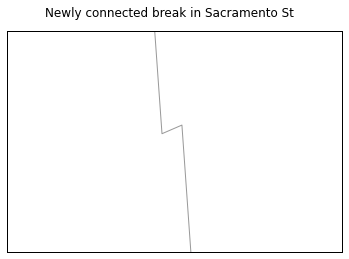

In [10]:
ax=gpd.GeoSeries(sac_st_merged).plot()
plt.axis([-200576,-200453,-12910,-12829])
ax.set_xticks([])
ax.set_yticks([])
title=plt.suptitle('Newly connected break in Sacramento St',size='12')

## Issue 2: Make Line Feature end at Polygon Boundaries

The next set of issues that we face is the fact that Sacramento Street does not end at the city boundaries. The northern end of Sacramento St falls short of boundary of the city and the southern end of Sacramento Street extends beyond the city boundary (see below for plots of both). The second issue isn't really an issue for this task - the city can still be divided by a line segment that extends beyond the polygon boundary (I address it anyway just to make the data cleaner). However, the first issue does need to be dealt with: in order to divide the city boundary in two, we need a line segment that intersects the boundary.

In terms of addressing the fact that Sacramento Street ends before the city boundary, there are multiple ways that the street can be extended. The most straightforward is to extend the line to the boundary in the shortest distance. A second way would be to extrapolate the line to the boundary following the angle of the previous line segment. If the line and the boundary are 90 degrees to each other, these two distances would be the same. The further from 90 degrees, the larger the difference between these two distances would be. As you can see below, the street at the northen boundary of Berkeley are pretty close to perpendicular to each other, so which method we use will not make a large difference.

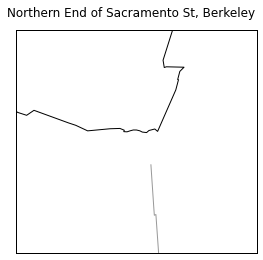

In [11]:
ax=gpd.GeoSeries(berk_boundary).plot(alpha=0)
ax=gpd.GeoSeries(sac_st_merged).plot()
plt.axis([-201160,-200044,-13041,-12005])
ax.set_xticks([])
ax.set_yticks([])
title=plt.suptitle('Northern End of Sacramento St, Berkeley',size='12')

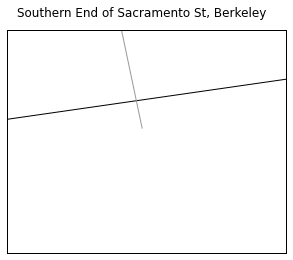

In [12]:
ax=gpd.GeoSeries(berk_boundary).plot(alpha=0)
ax=gpd.GeoSeries(sac_st_merged).plot()
plt.axis([-200138,-200133,-16367,-16363])
ax.set_xticks([])
ax.set_yticks([])
title=plt.suptitle('Southern End of Sacramento St, Berkeley',size='12')

### Creating function to test end point / polygon boundary relationships


To make things a bit easier, I will first write a function that describes the relationship between the endpoints of a line segment and a polygon that it intersects. This will be used to tell us whether each of the two endpoints of our dividing street are inside the boundary, outside the boundary, or on the boundary as well as their distance to the boundary. 

When applied to Sacramento St in Berkeley, the function tells us that one of the endpoints falls 150.9 meters short of the boundary and that the other falls 0.5 meters outside the boundary.

In [13]:
def get_endpoint_boundary_relationships(dividing_line, boundary_polygon, printdist=False):
    endpoint1, endpoint2=Point(dividing_line.coords[0]),Point(dividing_line.coords[-1])
    end_point_dict={}
    for i,endpoint in enumerate([endpoint1, endpoint2],1):
        dist_to_bounds=endpoint.distance(boundary_polygon.exterior)
        if endpoint.touches(boundary_polygon):
            if printdist: print 'End point '+str(i)+ ' '+str(endpoint.coords[0])+' falls on the boundary'
            end_point_dict[endpoint.coords[0]]='boundary'        
        if endpoint.within(boundary_polygon):
            if printdist: print 'End point '+str(i)+ ' '+str(endpoint.coords[0])+ ' falls '+\
                str(round(dist_to_bounds,1))+ ' units short of the boundary'
            end_point_dict[endpoint.coords[0]]='inside'        
        if endpoint.disjoint(boundary_polygon):
            if printdist: print 'End point '+str(i)+ ' '+str(endpoint.coords[0])+' falls ' +\
                str(round(dist_to_bounds,1))+ ' units beyond the boundary'
            end_point_dict[endpoint.coords[0]]='outside'        
    return end_point_dict
        
sac_st_endpoints=get_endpoint_boundary_relationships(sac_st_merged, berk_boundary, printdist=True)

End point 1 (-200534.9861220776, -12632.523232849315) falls 150.9 units short of the boundary
End point 2 (-200135.58194010626, -16364.76590784965) falls 0.5 units beyond the boundary


### Developing Sample Data 
Now I'll write a series of functions that can be used to extend the road feature to the boundary as well as clip it at the boundary. To make things easier to visualize, for now I'll just use an example polygon and line, and will apply them to our real data afterwards.

As shown below, the example polygon and linestring have the same issue that we're facing - one endpoint falls short of the boundary and one falls outside the boundary.

End point 1 (-0.5, 5.0) falls 0.5 units beyond the boundary
End point 2 (6.0, 9.0) falls 1.0 units short of the boundary


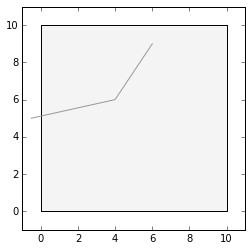

In [14]:
example_poly=Polygon([(0,0),(10,0),(10,10),(0,10)])
example_line=LineString([(-.5,5),(4,6,),(6,9)])
gpd.GeoSeries(example_poly).plot(alpha=.1)
gpd.GeoSeries([example_line]).plot()
plt.axis([-1,11,-1,11])

relat=get_endpoint_boundary_relationships(example_line,example_poly,printdist=True)

### Method 1: Extend LineString by Shortest Distance

First I will write a function that extends a LineString's endpoint to the boundary by means of the shortest distance. The function identifies endpoints that fall within the boundary and uses the Shapely functions ```interpolate``` and ```project``` to identify the location on the boundary that the LineString should be extended to. ```project``` calculates the distance along the boundary that is closest to the end point and then ```interpolate``` returns the Point on the boundary that is located at this specified distance.

After apply the function to the example polygon and line we see visually that the line segment is extended, and also get confirmation that the end point now falls on the boundary (by using the previously defined function)

End point 1 (-0.5, 5.0) falls 0.5 units beyond the boundary
End point 2 (6.0, 10.0) falls on the boundary


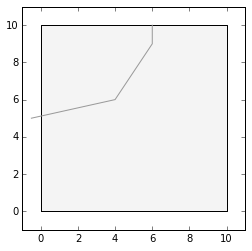

In [15]:
def extend_to_boundary(dividing_line, boundary_polygon):
    endpoints=[Point(dividing_line.coords[0]),Point(dividing_line.coords[-1])]
    #identify those endpoints that are within the polygon boundary and loop through them
    interior_endpoints=[x for x in endpoints if x.within(boundary_polygon)]
    new_segments=[]
    for interior_endpoint in interior_endpoints:
        #calculate the location on the polygon boundary that is closest to the endpoint
        new_endpoint=boundary_polygon.exterior.interpolate(boundary_polygon.exterior.project(interior_endpoint))
        #draw a new line segment that extends to this new end point
        new_segments.append(LineString([interior_endpoint,new_endpoint]))
    return linemerge([dividing_line]+new_segments)

extended_segment=extend_to_boundary(example_line, example_poly)
gpd.GeoSeries(example_poly).plot(alpha=.1)
gpd.GeoSeries(extended_segment).plot()
plt.axis([-1,11,-1,11])

z=get_endpoint_boundary_relationships(extended_segment, example_poly, printdist=True)

### Method 2: Extend LineString by Extrapolation

Next I will write a function that extends a LineString's endpoint to the boundary by means of extrapolating. This means the line segment closest to the boundary will be extended at the same angle until it hits the boundary. 

This function is a bit more complicated. I first identify the line segments that needs to me extrapolated (in this case there is only one), and then loop through them. For each line segment that needs to be extrapolated I calculate the slope of the end segment and then use some basic algrebra to extend the segment at this same angle. The extended segment goes beyond the polygon bounds and is then clipped so that it's end point is on the boundary.

Again, I will then apply this function to our example geometries and see that the line was extended appropriately. As can be seen below, the line now reaches the polygon boundary not by means of the shorest distance, but my means of extrapolation.

End point 1 (-0.5, 5.0) falls 0.5 units beyond the boundary
End point 2 (6.666666666666671, 10.0) falls on the boundary


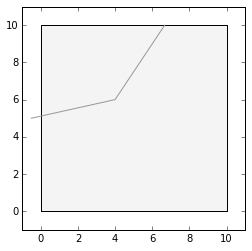

In [16]:
def extend_to_boundary_extrap(dividing_line, boundary_polygon, max_extrap=100):
    #Get the two line segments on either end of the LineString. 
    endsegments=[[dividing_line.coords[1],dividing_line.coords[0]],\
                 [dividing_line.coords[-2],dividing_line.coords[-1]]]
    
    #Identify which of those segments have an endpoint that is located within the polygon and 
    #therefore needs to be extrapolated
    interior_endsegments=[pt for pt in endsegments if Point(pt[1]).within(boundary_polygon)]
    
    #Loop through these segments that need to be extrapolated and extend them to they reach the boundary
    new_segments=[]
    for interior_endsegment in interior_endsegments:
        #Determine the two endpoints of the segment and calculate the slope that the segment will be extended at
        endpoint_x,endpoint_y=interior_endsegment[1][0],interior_endsegment[1][1]

        prev_point_x, prev_point_y=interior_endsegment[0][0],interior_endsegment[0][1]
        m=(prev_point_y-endpoint_y)/(prev_point_x-endpoint_x)
        
        #Use basic algebra and geometry to create a line that will extend further than necessary
        #We use the specified "max_extrap" variable which represents the maximum distance we're willing to extrapolate
        r=sqrt(1+m**2)
        long_line=LineString([(endpoint_x+max_extrap/r, endpoint_y+max_extrap*m/r),\
                              (endpoint_x-max_extrap/r, endpoint_y-max_extrap*m/r)]) 
        
        #If the endpoint is within the max extrapolation distance, make it's new endpoint 
        #coordinates the point at which it intersects the boundary
        if boundary_polygon.exterior.intersects(long_line):
            new_endpoint_coords=boundary_polygon.intersection(long_line).coords[0]
            new_segment=LineString([(endpoint_x,endpoint_y), new_endpoint_coords])
            new_segments.append(new_segment)
        else:
            print 'New line does not intersect boundary after extrapolation'
        
        return linemerge([dividing_line]+new_segments)
extend_to_boundary_extrap(example_line,example_poly)
extrapolated_segment=extend_to_boundary_extrap(example_line,example_poly)
gpd.GeoSeries(example_poly).plot(alpha=.1)
gpd.GeoSeries(extrapolated_segment).plot()
plt.axis([-1,11,-1,11])

z=get_endpoint_boundary_relationships(extrapolated_segment, example_poly, printdist=True)

It is interesting to compare the previous two plots as to get a sense of how the two methods of extending the line vary in their end result.

### Clipping LineString at Polygon Boundary
Our last step is just to write a function that cuts the line segment that extends past the boundary. This is a pretty simple task that just uses Shapely's ```intersection``` funcion. As we can see below, when applied to our previous extrapolated version of the LineString, both end points now fall on the Polygon boundaries.

End point 1 (0.0, 5.111111111111111) falls on the boundary
End point 2 (6.666666666666671, 10.0) falls on the boundary


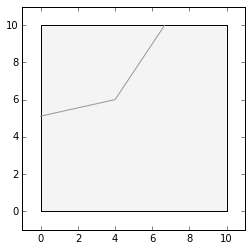

In [17]:
def cut_line_at_poly(dividing_line, boundary_polygon):
    return dividing_line.intersection(boundary_polygon)

cut_line=cut_line_at_poly(extrapolated_segment, example_poly)
gpd.GeoSeries(example_poly).plot(alpha=.1)
gpd.GeoSeries(cut_line).plot()
plt.axis([-1,11,-1,11])

z=get_endpoint_boundary_relationships(cut_line, example_poly, printdist=True)

### Applying Functions to Berkeley Data

Now that these functions are written and proven to work on our example data, we will apply them to Sacramento St in Berkeley. I write a simple function that wraps the 3 functions into one. By default, when extending a LineString to the boundary I will use the function that extends by means of closest point, but allow the user to choose the extrapolate function instead.

As can be seen in the two maps below, the topological issues with the line segment have now been resolved

In [18]:
def clean_line_ends(dividing_line, boundary_polygon, extrapolate=False):
    cut_line=cut_line_at_poly(dividing_line,boundary_polygon)
    if extrapolate:
        cleaned_line=extend_to_boundary_extrap(cut_line, boundary_polygon)
    else:
        cleaned_line=extend_to_boundary(cut_line, boundary_polygon)

    return cleaned_line

[]

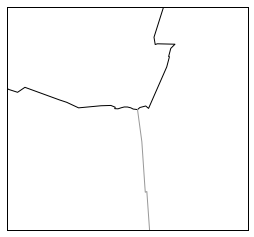

In [19]:
sac_st_final=clean_line_ends(sac_st_merged,berk_boundary)

ax=gpd.GeoSeries(berk_boundary).plot(alpha=0)
ax=gpd.GeoSeries(sac_st_final).plot()
plt.axis([-201160,-200044,-13041,-12005])

ax.set_xticks([])
ax.set_yticks([])

[]

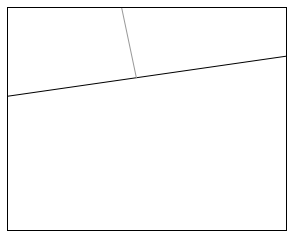

In [20]:
ax=gpd.GeoSeries(berk_boundary).plot(alpha=0)
ax=gpd.GeoSeries(sac_st_final).plot()
plt.axis([-200138,-200133,-16367,-16363])
ax.set_xticks([])
ax.set_yticks([])

## Creating Divided City Boundary

Lastly, we will take our newly cleaned Sacramento St approximation that will be used to divide the city and actually cut the city into two polygons. This can be done pretty easily in 1 line by using a few Shapely operations linked together.

Built into one line of code, I first take the exterior boundary of the city, which is represented as a LineString. I then take the ```union``` of that with the dividing street, which results in a merged LineString. Finally I use the ```polygonize``` function, which returns the Polygons that are created from list of lines.

I then plot the new list of polygons and as you can see we have successfully divided Berkeley at Sacramento St!

[]

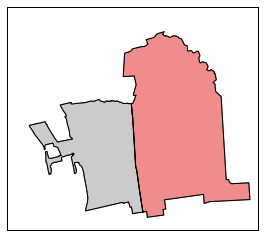

In [21]:
split_polygon_list=list(polygonize(berk_boundary.exterior.union(sac_st_final)))
ax=gpd.GeoSeries(split_polygon_list).plot()

ax.set_xticks([])
ax.set_yticks([])

## Conclusion
This example demonstrates how Python can be used to implement various topological rules, which were required to create the desired output. 

I required that:

1. Noncontiguous streets with endpoints less than 10 meters apart are snapped together
2. Line features start and end at the boundaries of the polygon they are located within

Using these geometric features in Shapely I could create other customized tools to edit geometries to conform to common topological rules such as overlapping polygons, gapped polygons, dangling lines, self-overlapping lines, etc.